<h1 style="text-align:center;">Task 3 – UrbanSound8K Audio Classification</h1>

This task classifies urban environmental sounds (car horn, dog bark, siren, etc.) from the UrbanSound8K dataset. The analysis compares classical machine learning models trained on extracted audio features (MFCCs, chroma, spectral contrast) with a CNN trained on mel-spectrograms. Explainability analysis using SHAP interprets feature importance, and K-Means clustering explores unsupervised patterns in the audio data.


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 1</h2>

In [9]:
## step 1, imports and setup.
# here we import all necessary libraries for audio processing, feature extraction, classical ML, and deep learning.

# debugging notes:
# - using librosa for audio loading and feature extraction (MFCCs, chroma, spectral contrast).
# - pytorch for CNN model on spectrograms instead of tensorflow (better windows compatibility).
# - sklearn for classical ML models (SVM, Random Forest, XGBoost).
# - shap for model explainability and feature importance.
# - matplotlib/seaborn for visualization with dark background theme.
# - all random seeds set for reproducibility.
# - CPU mode by default (GPU optional if cuda available).

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# xgboost
import xgboost as xgb
# did this through import pip install xgboost cause it was giving me issues otherwise

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# shap for explainability
import shap

# set random seeds for reproducibility
RANDOM_STATE = 67
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set plot style
plt.style.use('dark_background')

print(f"librosa version: {librosa.__version__}")
print(f"pytorch version: {torch.__version__}")
print(f"using device: {device}")


librosa version: 0.11.0
pytorch version: 2.9.1+cpu
using device: cpu


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 2</h2>

### Data loading and metadata preparation

The UrbanSound8K dataset is organized into 10 folds, each containing audio files (.wav) and metadata (CSV). We load the metadata file to map each audio file to its class label, then prepare paths for all audio samples. Class distribution is analyzed to check for imbalance.


total audio files: 8732

metadata columns: ['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class']

first 5 rows:
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  

class distribution:
class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot         

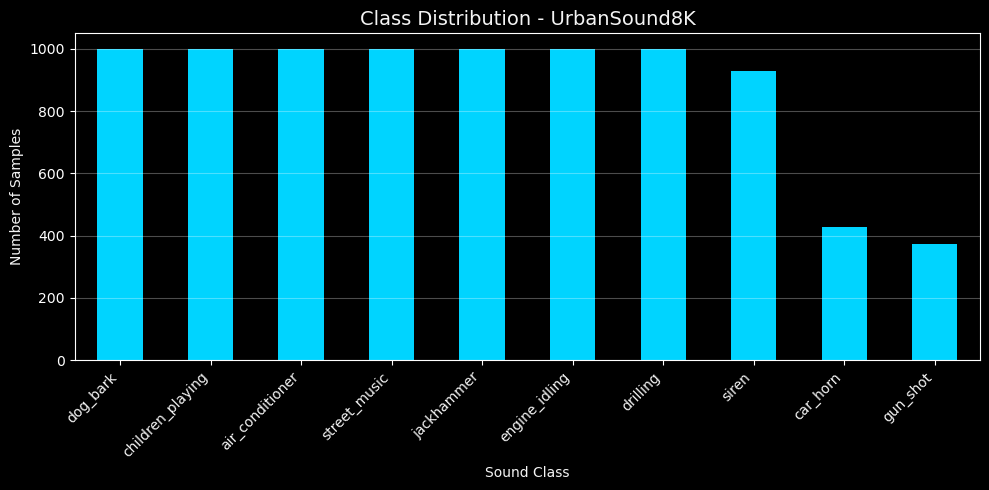


total samples: 8732
unique classes: 10


In [11]:
## step 2, data loading and metadata preparation.
# here we load audio file paths and labels from UrbanSound8K metadata.

# debugging notes:
# - UrbanSound8K structure: audio files in fold1-fold10 folders, metadata in CSV.
# - metadata contains: slice_file_name, fold, classID, class (label).
# - loading all audio paths and corresponding labels for processing.
# - checking class distribution to identify any imbalance.

# define paths
DATA_PATH = "data"
AUDIO_PATH = os.path.join(DATA_PATH, "audio")  # audio files are in data/audio/fold1, fold2, etc.
METADATA_PATH = os.path.join(DATA_PATH, "metadata", "UrbanSound8K.csv")  # CSV is in data/metadata/

# load metadata
metadata = pd.read_csv(METADATA_PATH)

print(f"total audio files: {len(metadata)}")
print(f"\nmetadata columns: {metadata.columns.tolist()}")
print(f"\nfirst 5 rows:")
print(metadata.head())

# create full file paths
metadata['file_path'] = metadata.apply(
    lambda row: os.path.join(AUDIO_PATH, f"fold{row['fold']}", row['slice_file_name']), axis=1
)

# check class distribution
class_counts = metadata['class'].value_counts()
print(f"\nclass distribution:")
print(class_counts)

# visualize class distribution
plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar', color='#00d4ff')
plt.title("Class Distribution - UrbanSound8K", color='#f4f4f4', fontsize=14)
plt.xlabel("Sound Class", color='#f4f4f4')
plt.ylabel("Number of Samples", color='#f4f4f4')
plt.xticks(rotation=45, ha='right', color='#f4f4f4')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# extract labels
labels = metadata['class'].values
labels_encoded = metadata['classID'].values

print(f"\ntotal samples: {len(labels)}")
print(f"unique classes: {len(np.unique(labels))}")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 3</h2>

### Audio feature extraction

Classical ML models require numerical features extracted from raw audio. We extract three types of features: MFCCs (Mel-Frequency Cepstral Coefficients) for timbral texture, Chroma features for pitch content, and Spectral Contrast for frequency distribution patterns. Features are aggregated by taking mean and standard deviation across time frames.


In [12]:
## step 3, audio feature extraction for classical ML.
# here we extract MFCCs, chroma, and spectral contrast features from each audio file.

# debugging notes:
# - MFCCs: capture timbral characteristics (13 coefficients).
# - Chroma: capture pitch/harmonic content (12 bins).
# - Spectral Contrast: capture frequency distribution differences (7 bands).
# - aggregating mean + std across time frames for each feature.
# - damn who knew 8732 audio files would take this long to extract features ;-;.
# - using sample rate of 22050 Hz (librosa default).

def extract_features(file_path, sr=22050, duration=4):
    """extract MFCC, chroma, and spectral contrast features from audio file"""
    try:
        # load audio (limit to 4 seconds max to standardize length)
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        
        # extract MFCCs (13 coefficients)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        
        # extract chroma features (12 bins)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_std = np.std(chroma, axis=1)
        
        # extract spectral contrast (7 bands)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        contrast_mean = np.mean(contrast, axis=1)
        contrast_std = np.std(contrast, axis=1)
        
        # concatenate all features
        features = np.concatenate([mfcc_mean, mfcc_std, chroma_mean, chroma_std, contrast_mean, contrast_std])
        
        return features
    except Exception as e:
        print(f"error processing {file_path}: {e}")
        return None

# extract features from all audio files
print("extracting audio features (this may take 5-10 minutes)...")
X_features = []
valid_labels = []

for idx, row in tqdm(metadata.iterrows(), total=len(metadata), desc="processing audio"):
    features = extract_features(row['file_path'])
    if features is not None:
        X_features.append(features)
        valid_labels.append(row['classID'])

X_features = np.array(X_features)
valid_labels = np.array(valid_labels)

print(f"\nfeature extraction complete!")
print(f"feature matrix shape: {X_features.shape}")
print(f"features per audio file: {X_features.shape[1]}")
print(f"valid samples: {len(valid_labels)}")


extracting audio features (this may take 5-10 minutes)...


processing audio: 100%|██████████| 8732/8732 [05:32<00:00, 26.28it/s]


feature extraction complete!
feature matrix shape: (8732, 64)
features per audio file: 64
valid samples: 8732


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 4</h2>

### Sample spectrogram visualization

Spectrograms are visual representations of audio signals showing how frequency content changes over time. We display mel-spectrograms for 6 random audio samples (one from each of 6 different classes) to illustrate the diversity of urban sound patterns.


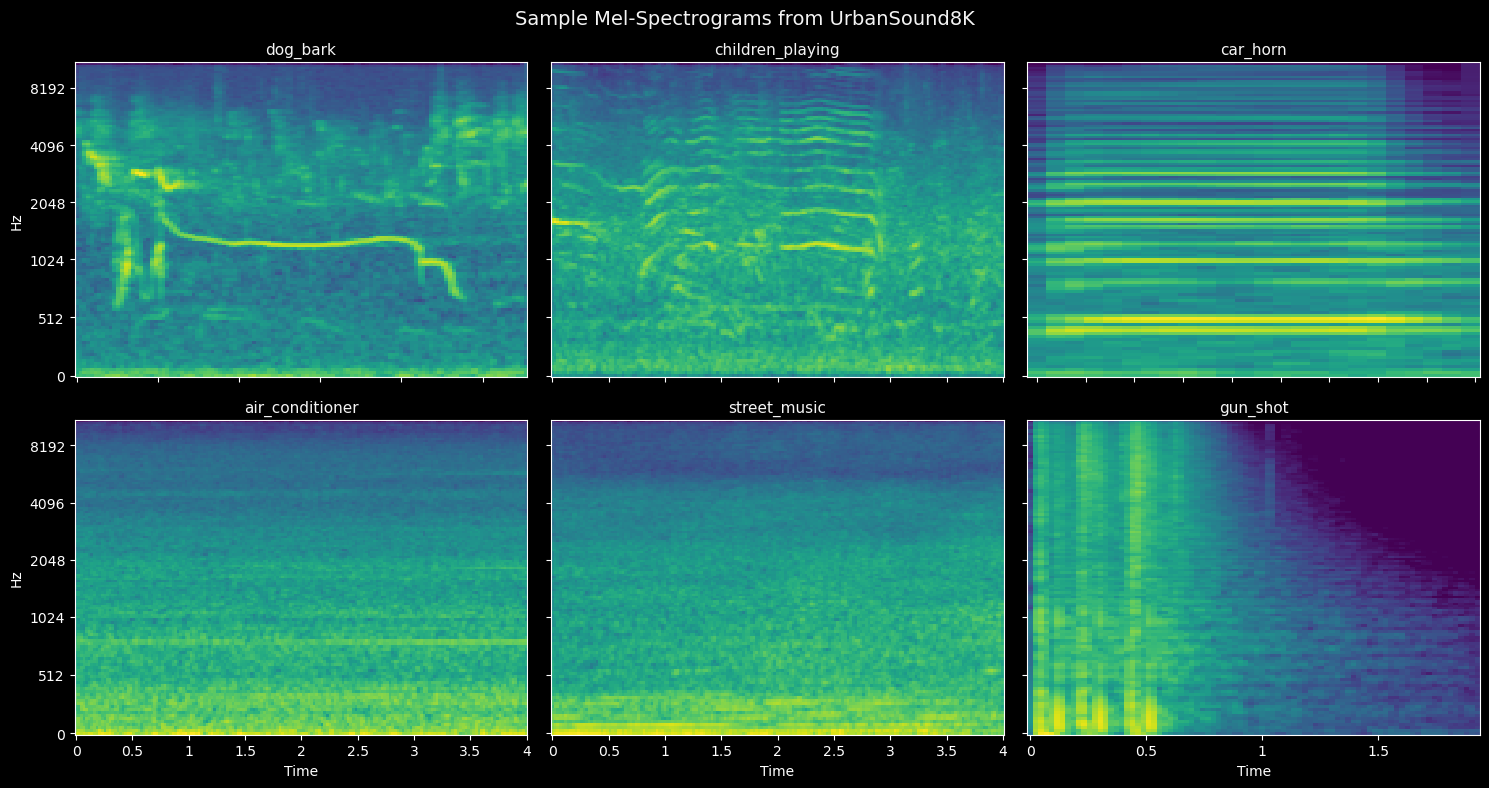

displayed spectrograms for 6 audio samples


In [13]:
## step 4, sample spectrogram visualization.
# here we visualize mel-spectrograms for sample audio files from different classes.

# debugging notes:
# - mel-spectrograms show frequency (mel scale) vs time with amplitude as color.
# - selecting 6 random samples from different classes for diversity.
# - using librosa.display for proper spectrogram plotting.

# select one sample from each of first 6 classes
sample_classes = metadata['class'].unique()[:6]
sample_indices = []

for cls in sample_classes:
    cls_samples = metadata[metadata['class'] == cls]
    sample_idx = cls_samples.sample(1, random_state=RANDOM_STATE).index[0]
    sample_indices.append(sample_idx)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, sample_idx in enumerate(sample_indices):
    row = metadata.iloc[sample_idx]
    audio, sr = librosa.load(row['file_path'], sr=22050, duration=4)
    
    # compute mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # plot
    img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[idx], cmap='viridis')
    axes[idx].set_title(f"{row['class']}", fontsize=11, color='#f4f4f4')
    axes[idx].label_outer()

plt.suptitle("Sample Mel-Spectrograms from UrbanSound8K", fontsize=14, color='#f4f4f4')
plt.tight_layout()
plt.show()

print(f"displayed spectrograms for {len(sample_indices)} audio samples")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 5</h2>

### Train–validation–test setup and classical ML models

The extracted feature dataset is split into training (70%), validation (15%), and test (15%) sets. Features are standardized using StandardScaler. Three classical ML models are trained: SVM (Support Vector Machine), Random Forest, and XGBoost (Gradient Boosting).


In [14]:
## step 5, train classical ML models.
# here we split data, standardize features, and train SVM/Random Forest/XGBoost.

# debugging notes:
# - 70/15/15 train/val/test split.
# - StandardScaler applied to features for better model convergence.
# - SVM: RBF kernel (can take a while on CPU).
# - Random Forest: 100 trees.
# - XGBoost: 100 estimators with GPU support if available.
# - evaluation on validation set first, test set later.

# split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_features, valid_labels, test_size=0.3, random_state=RANDOM_STATE, stratify=valid_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"train set: {X_train.shape[0]} samples")
print(f"validation set: {X_val.shape[0]} samples")
print(f"test set: {X_test.shape[0]} samples")

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# train classical ML models
print("\ntraining classical ML models...")

# SVM
print("\n1. training SVM (this may take a while)...")
svm_model = SVC(kernel='rbf', random_state=RANDOM_STATE)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_val_scaled)
svm_acc = accuracy_score(y_val, svm_pred)
svm_f1 = precision_recall_fscore_support(y_val, svm_pred, average='weighted', zero_division=0)[2]
print(f"SVM validation accuracy: {svm_acc:.4f}")
print(f"SVM validation F1-score: {svm_f1:.4f}")

# Random Forest
print("\n2. training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_val_scaled)
rf_acc = accuracy_score(y_val, rf_pred)
rf_f1 = precision_recall_fscore_support(y_val, rf_pred, average='weighted', zero_division=0)[2]
print(f"Random Forest validation accuracy: {rf_acc:.4f}")
print(f"Random Forest validation F1-score: {rf_f1:.4f}")

# XGBoost
print("\n3. training XGBoost...")
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='mlogloss', use_label_encoder=False)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_val_scaled)
xgb_acc = accuracy_score(y_val, xgb_pred)
xgb_f1 = precision_recall_fscore_support(y_val, xgb_pred, average='weighted', zero_division=0)[2]
print(f"XGBoost validation accuracy: {xgb_acc:.4f}")
print(f"XGBoost validation F1-score: {xgb_f1:.4f}")

# store results
classical_results = {
    'SVM': {'model': svm_model, 'accuracy': svm_acc, 'f1': svm_f1, 'predictions': svm_pred},
    'Random Forest': {'model': rf_model, 'accuracy': rf_acc, 'f1': rf_f1, 'predictions': rf_pred},
    'XGBoost': {'model': xgb_model, 'accuracy': xgb_acc, 'f1': xgb_f1, 'predictions': xgb_pred}
}

print("\nclassical ML training complete!")


train set: 6112 samples
validation set: 1310 samples
test set: 1310 samples

training classical ML models...

1. training SVM (this may take a while)...
SVM validation accuracy: 0.8901
SVM validation F1-score: 0.8903

2. training Random Forest...
Random Forest validation accuracy: 0.8924
Random Forest validation F1-score: 0.8926

3. training XGBoost...
XGBoost validation accuracy: 0.9160
XGBoost validation F1-score: 0.9162

classical ML training complete!


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 6</h2>

### Classical machine learning evaluation

Detailed performance metrics (accuracy, precision, recall, F1-score) are computed for each classical model. Confusion matrices visualize classification patterns and help identify which sound classes are most challenging to distinguish.



SVM - Detailed Metrics
Accuracy:  0.8901
Precision: 0.8920
Recall:    0.8901
F1-Score:  0.8903


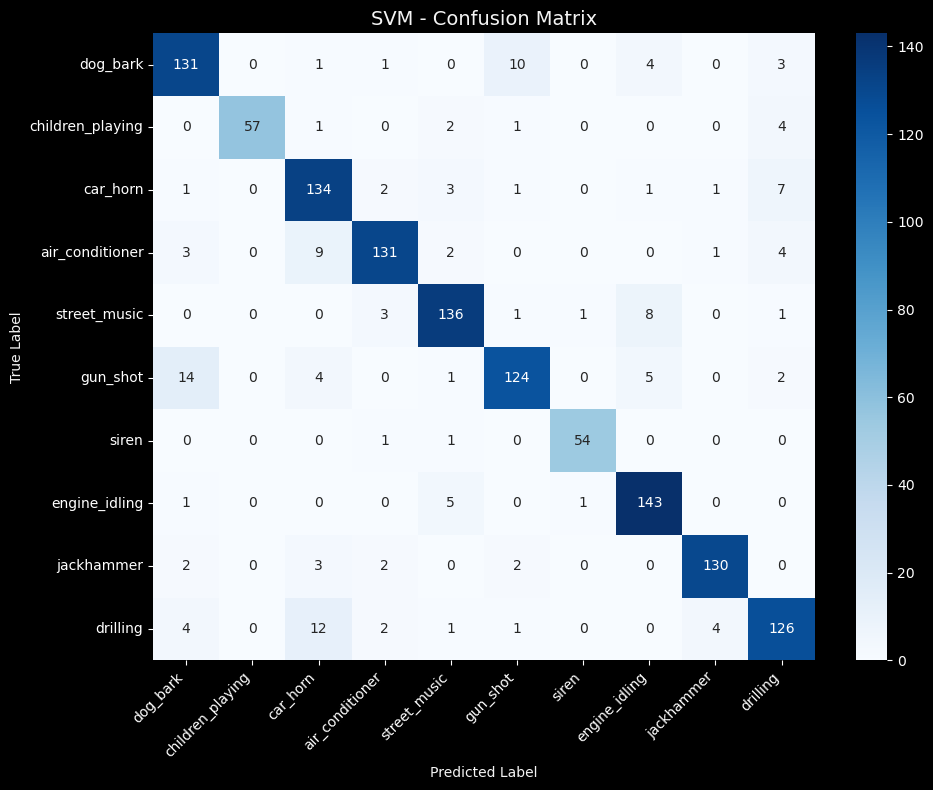


Random Forest - Detailed Metrics
Accuracy:  0.8924
Precision: 0.8955
Recall:    0.8924
F1-Score:  0.8926


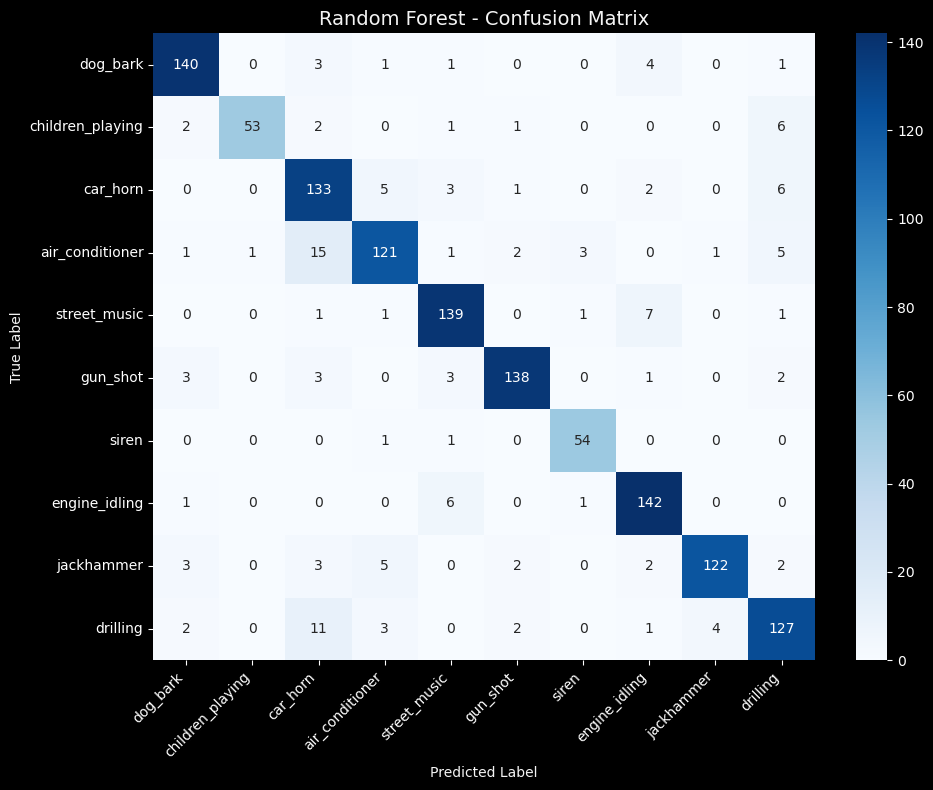


XGBoost - Detailed Metrics
Accuracy:  0.9160
Precision: 0.9171
Recall:    0.9160
F1-Score:  0.9162


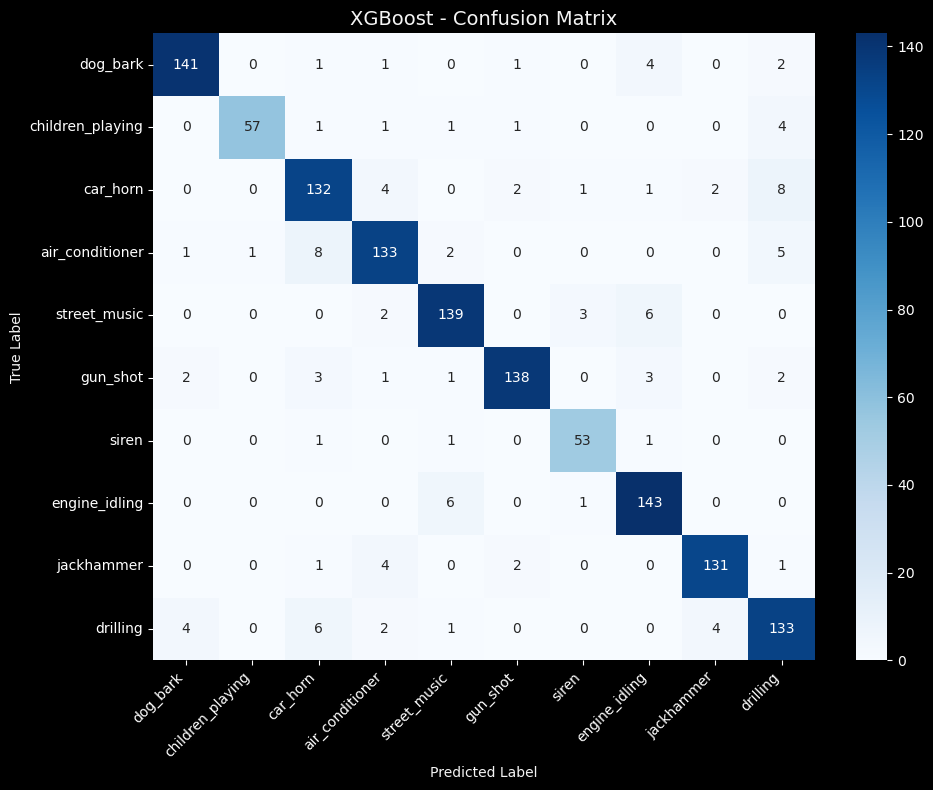


Best Classical Model: XGBoost
Best Validation F1-Score: 0.9162


In [15]:
## step 6, classical ML evaluation and visualization.
# here we compute detailed metrics and plot confusion matrices for classical models.

# debugging notes:
# - computing precision, recall, f1-score for each model.
# - confusion matrices show per-class performance.
# - using validation set for evaluation.

# class names for confusion matrix labels
class_names = metadata['class'].unique()

# evaluate each model
for model_name, results in classical_results.items():
    print(f"\n{'='*50}")
    print(f"{model_name} - Detailed Metrics")
    print(f"{'='*50}")
    
    y_pred = results['predictions']
    
    # compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy:  {results['accuracy']:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix", color='#f4f4f4', fontsize=14)
    plt.xlabel("Predicted Label", color='#f4f4f4')
    plt.ylabel("True Label", color='#f4f4f4')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# identify best classical model
best_classical_name = max(classical_results, key=lambda k: classical_results[k]['f1'])
best_classical_f1 = classical_results[best_classical_name]['f1']

print(f"\n{'='*50}")
print(f"Best Classical Model: {best_classical_name}")
print(f"Best Validation F1-Score: {best_classical_f1:.4f}")
print(f"{'='*50}")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 7</h2>

### Deep learning model on spectrograms

A Convolutional Neural Network (CNN) is trained directly on mel-spectrogram images rather than hand-crafted features. This allows the model to learn hierarchical representations of audio patterns. A custom CNN architecture is built with convolutional layers for feature extraction followed by fully connected layers for classification.


In [21]:
## step 7, deep learning CNN on mel-spectrograms.
# here we build a CNN to classify audio based on spectrogram images.

# debugging notes:
# - converting audio to mel-spectrograms (128 mel bins x time frames).
# - CNN architecture: 3 conv blocks + 2 FC layers.
# - training for 15 epochs (can adjust if needed).
# - using Adam optimizer with learning rate 0.001.
# - batch size 32 (reduce if out of memory).
# - spectrograms stored as numpy arrays to avoid recomputing during training.

# function to convert audio to mel-spectrogram
def audio_to_melspec(file_path, sr=22050, duration=4, n_mels=128):
    """convert audio file to mel-spectrogram"""
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        
        # pad or trim to fixed length
        target_length = sr * duration
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]
        
        # compute mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        return mel_spec_db
    except Exception as e:
        print(f"error processing {file_path}: {e}")
        return None

# extract spectrograms for all audio files
print("converting audio to mel-spectrograms for CNN...")
spectrograms = []
spec_labels = []

for idx, row in tqdm(metadata.iterrows(), total=len(metadata), desc="generating spectrograms"):
    spec = audio_to_melspec(row['file_path'])
    if spec is not None:
        spectrograms.append(spec)
        spec_labels.append(row['classID'])

spectrograms = np.array(spectrograms)
spec_labels = np.array(spec_labels)

# add channel dimension for CNN (grayscale)
spectrograms = np.expand_dims(spectrograms, axis=1)

print(f"\nspectrogram conversion complete!")
print(f"spectrogram shape: {spectrograms.shape}")  # (num_samples, 1, n_mels, time_frames)

# split spectrogram data
X_train_spec, X_temp_spec, y_train_spec, y_temp_spec = train_test_split(
    spectrograms, spec_labels, test_size=0.3, random_state=RANDOM_STATE, stratify=spec_labels
)
X_val_spec, X_test_spec, y_val_spec, y_test_spec = train_test_split(
    X_temp_spec, y_temp_spec, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp_spec
)

print(f"train spectrograms: {X_train_spec.shape[0]}")
print(f"validation spectrograms: {X_val_spec.shape[0]}")
print(f"test spectrograms: {X_test_spec.shape[0]}")

# custom dataset for spectrograms
class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms, labels):
        self.spectrograms = torch.FloatTensor(spectrograms)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

# create dataloaders
BATCH_SIZE = 32
train_spec_dataset = SpectrogramDataset(X_train_spec, y_train_spec)
val_spec_dataset = SpectrogramDataset(X_val_spec, y_val_spec)
test_spec_dataset = SpectrogramDataset(X_test_spec, y_test_spec)

train_spec_loader = DataLoader(train_spec_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_spec_loader = DataLoader(val_spec_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_spec_loader = DataLoader(test_spec_dataset, batch_size=BATCH_SIZE, shuffle=False)

# define CNN architecture
class AudioCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AudioCNN, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # calculate flattened size (depends on input shape)
        self.fc1 = nn.Linear(128 * 16 * 21, 256)  # adjust based on spectrogram size
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# build model
num_classes = len(np.unique(spec_labels))
cnn_model = AudioCNN(num_classes=num_classes).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

print(f"\nCNN model architecture:")
print(cnn_model)
print(f"device: {device}")


converting audio to mel-spectrograms for CNN...


generating spectrograms: 100%|██████████| 8732/8732 [01:46<00:00, 81.65it/s] 



spectrogram conversion complete!
spectrogram shape: (8732, 1, 128, 173)
train spectrograms: 6112
validation spectrograms: 1310
test spectrograms: 1310

CNN model architecture:
AudioCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=43008, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
device: cpu


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 8</h2>

### Train deep learning model

The CNN is trained for 15 epochs with training and validation accuracy/loss tracked at each epoch. Learning curves are plotted to visualize model convergence and detect potential overfitting. The trained model is then evaluated on the test set.



starting CNN training on spectrograms...

epoch 1/15


validation: 100%|██████████| 41/41 [00:05<00:00,  7.04it/s]


train loss: 2.4971 | train acc: 0.2984
val loss: 1.4149 | val acc: 0.4679

epoch 2/15


validation: 100%|██████████| 41/41 [00:05<00:00,  7.65it/s]


train loss: 1.3390 | train acc: 0.5322
val loss: 0.9541 | val acc: 0.7031

epoch 3/15


validation: 100%|██████████| 41/41 [00:05<00:00,  7.63it/s]


train loss: 1.0435 | train acc: 0.6450
val loss: 0.8333 | val acc: 0.7344

epoch 4/15


validation: 100%|██████████| 41/41 [00:05<00:00,  7.71it/s]


train loss: 0.9112 | train acc: 0.6908
val loss: 0.7956 | val acc: 0.7374

epoch 5/15


validation: 100%|██████████| 41/41 [00:05<00:00,  7.66it/s]


train loss: 0.7887 | train acc: 0.7345
val loss: 0.8024 | val acc: 0.7321

epoch 6/15


validation: 100%|██████████| 41/41 [00:05<00:00,  7.57it/s]


train loss: 0.6873 | train acc: 0.7595
val loss: 0.6224 | val acc: 0.7977

epoch 7/15


validation: 100%|██████████| 41/41 [00:05<00:00,  7.35it/s]


train loss: 0.5948 | train acc: 0.7929
val loss: 0.6006 | val acc: 0.8099

epoch 8/15


validation: 100%|██████████| 41/41 [00:05<00:00,  7.40it/s]


train loss: 0.5542 | train acc: 0.8127
val loss: 0.6025 | val acc: 0.8053

epoch 9/15


validation: 100%|██████████| 41/41 [00:05<00:00,  7.38it/s]


train loss: 0.4682 | train acc: 0.8441
val loss: 0.5588 | val acc: 0.8183

epoch 10/15


validation: 100%|██████████| 41/41 [00:05<00:00,  7.31it/s]


train loss: 0.4245 | train acc: 0.8523
val loss: 0.5524 | val acc: 0.8145

epoch 11/15


validation: 100%|██████████| 41/41 [00:04<00:00,  8.38it/s]


train loss: 0.3706 | train acc: 0.8760
val loss: 0.5685 | val acc: 0.8237

epoch 12/15


validation: 100%|██████████| 41/41 [00:04<00:00,  8.30it/s]


train loss: 0.3296 | train acc: 0.8884
val loss: 0.5884 | val acc: 0.8321

epoch 13/15


validation: 100%|██████████| 41/41 [00:04<00:00,  8.55it/s]


train loss: 0.3727 | train acc: 0.8758
val loss: 0.5999 | val acc: 0.8191

epoch 14/15


validation: 100%|██████████| 41/41 [00:05<00:00,  8.12it/s]


train loss: 0.2762 | train acc: 0.9033
val loss: 0.5871 | val acc: 0.8580

epoch 15/15


validation: 100%|██████████| 41/41 [00:04<00:00,  8.48it/s]


train loss: 0.2838 | train acc: 0.9043
val loss: 0.5382 | val acc: 0.8496

CNN training complete!


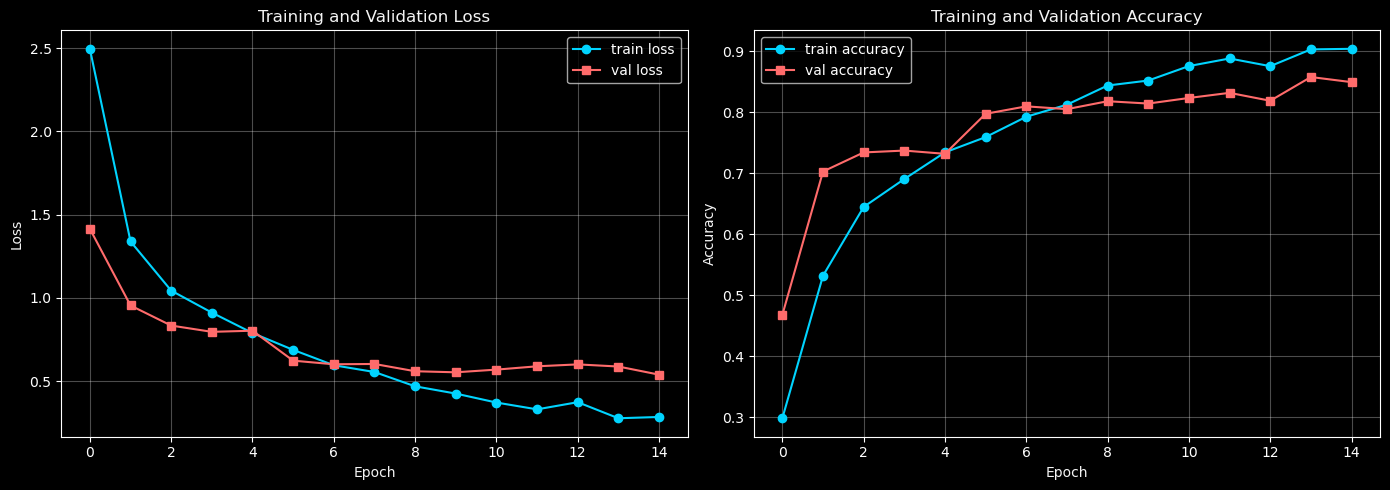


final validation accuracy: 0.8496

evaluating CNN on test set...


testing: 100%|██████████| 41/41 [00:04<00:00,  8.27it/s]



CNN - Test Set Results
Accuracy:  0.8740
Precision: 0.8762
Recall:    0.8740
F1-Score:  0.8743


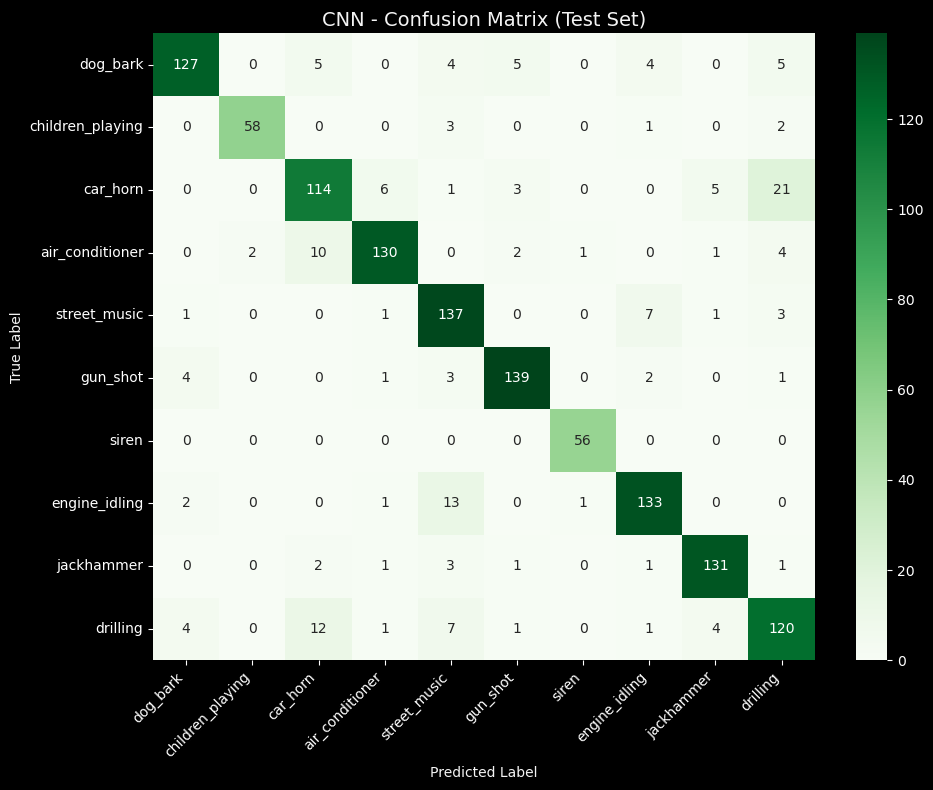


CNN evaluation complete!


In [22]:
## step 8, train CNN and track performance.
# here we train the CNN model on spectrograms and record training history.

# debugging notes:
# - training for 15 epochs (can adjust if needed).
# - tracking train/val loss and accuracy per epoch.
# - using tqdm for progress tracking.
# - model evaluation on validation set after each epoch.

EPOCHS = 15

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("\nstarting CNN training on spectrograms...")

for epoch in range(EPOCHS):
    print(f"\nepoch {epoch+1}/{EPOCHS}")
    
    # training phase
    cnn_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for spectrograms, labels in tqdm(train_spec_loader, desc="training"):
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        
        optimizer.zero_grad() 
        outputs = cnn_model(spectrograms)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_spec_loader)
    train_acc = train_correct / train_total
    
    # validation phase
    cnn_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for spectrograms, labels in tqdm(val_spec_loader, desc="validation"):
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            outputs = cnn_model(spectrograms)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_spec_loader)
    val_acc = val_correct / val_total
    
    # record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"train loss: {train_loss:.4f} | train acc: {train_acc:.4f}")
    print(f"val loss: {val_loss:.4f} | val acc: {val_acc:.4f}")

print("\nCNN training complete!")

# plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# loss curves
ax1.plot(history['train_loss'], label='train loss', marker='o', color='#00d4ff')
ax1.plot(history['val_loss'], label='val loss', marker='s', color='#ff6b6b')
ax1.set_xlabel('Epoch', color='#f4f4f4')
ax1.set_ylabel('Loss', color='#f4f4f4')
ax1.set_title('Training and Validation Loss', color='#f4f4f4')
ax1.legend()
ax1.grid(True, alpha=0.3)

# accuracy curves
ax2.plot(history['train_acc'], label='train accuracy', marker='o', color='#00d4ff')
ax2.plot(history['val_acc'], label='val accuracy', marker='s', color='#ff6b6b')
ax2.set_xlabel('Epoch', color='#f4f4f4')
ax2.set_ylabel('Accuracy', color='#f4f4f4')
ax2.set_title('Training and Validation Accuracy', color='#f4f4f4')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nfinal validation accuracy: {history['val_acc'][-1]:.4f}")

# evaluate CNN on test set
print("\nevaluating CNN on test set...")

cnn_model.eval()
cnn_predictions = []
cnn_true_labels = []

with torch.no_grad():
    for spectrograms, labels in tqdm(test_spec_loader, desc="testing"):
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        
        outputs = cnn_model(spectrograms)
        _, predicted = torch.max(outputs.data, 1)
        
        cnn_predictions.extend(predicted.cpu().numpy())
        cnn_true_labels.extend(labels.cpu().numpy())

cnn_predictions = np.array(cnn_predictions)
cnn_true_labels = np.array(cnn_true_labels)

# compute test metrics
cnn_acc = accuracy_score(cnn_true_labels, cnn_predictions)
cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(
    cnn_true_labels, cnn_predictions, average='weighted', zero_division=0
)

print(f"\n{'='*50}")
print(f"CNN - Test Set Results")
print(f"{'='*50}")
print(f"Accuracy:  {cnn_acc:.4f}")
print(f"Precision: {cnn_precision:.4f}")
print(f"Recall:    {cnn_recall:.4f}")
print(f"F1-Score:  {cnn_f1:.4f}")

# confusion matrix
cm_cnn = confusion_matrix(cnn_true_labels, cnn_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=class_names, yticklabels=class_names)
plt.title("CNN - Confusion Matrix (Test Set)", color='#f4f4f4', fontsize=14)
plt.xlabel("Predicted Label", color='#f4f4f4')
plt.ylabel("True Label", color='#f4f4f4')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nCNN evaluation complete!")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 9</h2>

### Explainability using SHAP

SHAP (SHapley Additive exPlanations) values are computed to understand which audio features (MFCCs, chroma, spectral contrast) contribute most to the best classical model's predictions. Feature importance is visualized using summary plots showing the impact of each feature across all samples.


computing SHAP values for XGBoost...
SHAP computation complete!


<Figure size 1000x800 with 0 Axes>

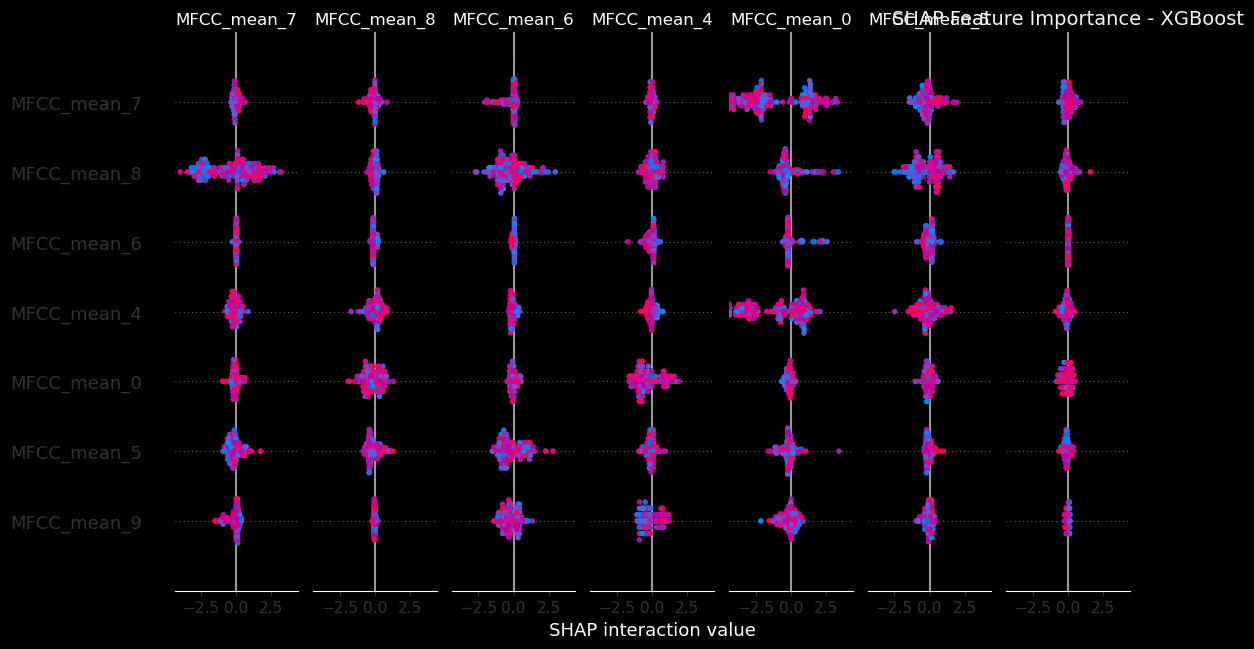


SHAP explainability analysis complete for XGBoost!


In [23]:
## step 9, explainability using SHAP.
# here we use SHAP to interpret feature importance for the best classical model.

# debugging notes:
# - using SHAP TreeExplainer (works for tree-based models like Random Forest/XGBoost).
# - if best model is SVM, we use KernelExplainer instead (slower but works for any model).
# - computing SHAP values on validation set (subset of 200 samples to save time).
# - visualizing feature importance summary plot.

print(f"computing SHAP values for {best_classical_name}...")

# select appropriate explainer based on model type
best_model = classical_results[best_classical_name]['model']

if best_classical_name in ['Random Forest', 'XGBoost']:
    # TreeExplainer for tree-based models (fast)
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_val_scaled[:200])  # subset to save time
else:
    # KernelExplainer for SVM (slower)
    print("using KernelExplainer (this may take a while)...")
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled[:100])
    shap_values = explainer.shap_values(X_val_scaled[:200])

print("SHAP computation complete!")

# create feature names
feature_names = (
    [f'MFCC_mean_{i}' for i in range(13)] +
    [f'MFCC_std_{i}' for i in range(13)] +
    [f'Chroma_mean_{i}' for i in range(12)] +
    [f'Chroma_std_{i}' for i in range(12)] +
    [f'Contrast_mean_{i}' for i in range(7)] +
    [f'Contrast_std_{i}' for i in range(7)]
)

# plot SHAP summary
plt.figure(figsize=(10, 8))

if isinstance(shap_values, list):
    # multi-class case: average SHAP values across classes
    shap_values_avg = np.mean(np.abs(shap_values), axis=0)
    shap.summary_plot(shap_values_avg, X_val_scaled[:200], feature_names=feature_names, show=False)
else:
    shap.summary_plot(shap_values, X_val_scaled[:200], feature_names=feature_names, show=False)

plt.title(f"SHAP Feature Importance - {best_classical_name}", fontsize=14, color='#f4f4f4')
plt.tight_layout()
plt.show()

print(f"\nSHAP explainability analysis complete for {best_classical_name}!")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 10</h2>

### Unsupervised clustering using K-Means

K-Means clustering is applied to the extracted MFCC features to discover natural groupings in the audio data without using labels. We compare the unsupervised clusters with the true sound classes using the Adjusted Rand Index (ARI) to measure how well the clusters align with actual categories.


K-Means Clustering Results:
Number of clusters: 10
Adjusted Rand Index (ARI): 0.1600

computing t-SNE projection for visualization (this may take a minute)...


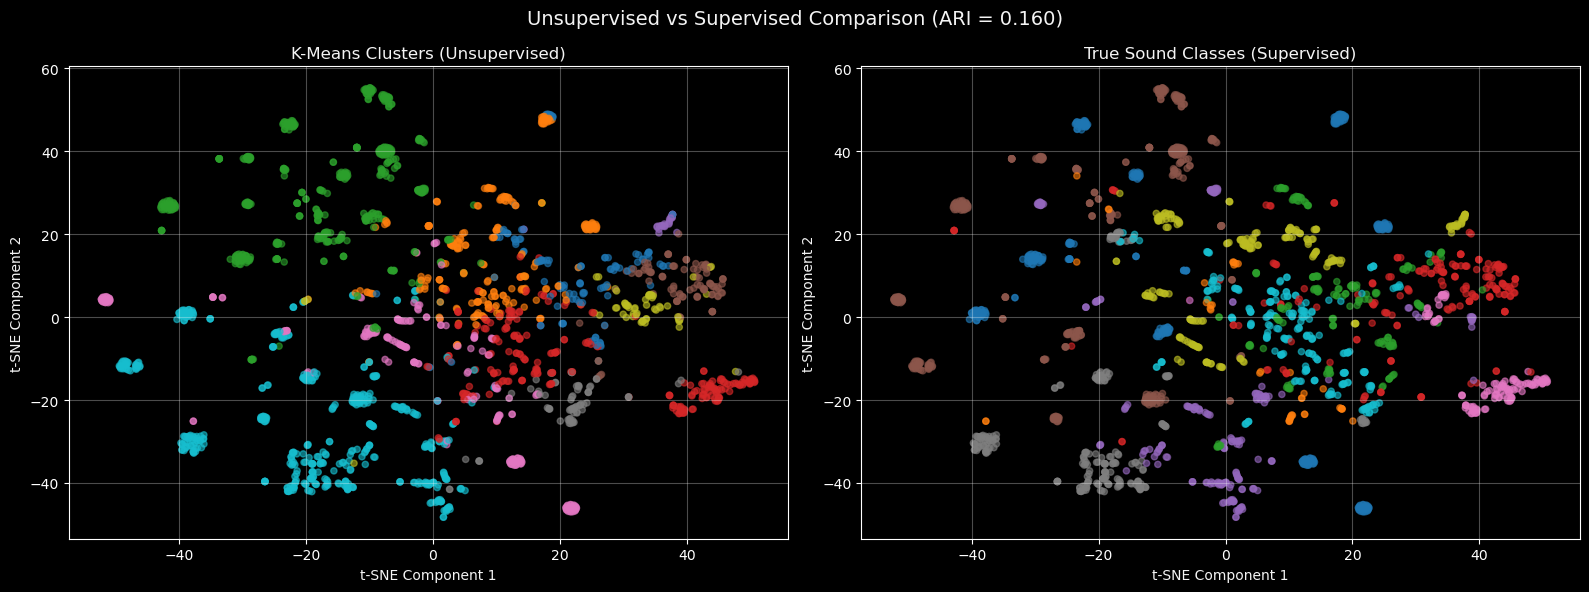


K-Means clustering analysis complete!
ARI interpretation: 1.0 = perfect match, 0.0 = random assignment


In [24]:
## step 10, unsupervised K-Means clustering and comparison.
# here we apply K-Means to MFCC features and compare clusters with true labels.

# debugging notes:
# - applying K-Means with k=10 (matching number of sound classes).
# - using scaled MFCC features only (first 26 features: mean + std).
# - computing Adjusted Rand Index (ARI) to measure cluster-label agreement.
# - visualizing clusters using t-SNE for 2D projection.

from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

# extract MFCC features only (first 26 columns)
mfcc_features = X_features[:, :26]

# scale MFCC features
mfcc_scaler = StandardScaler()
mfcc_scaled = mfcc_scaler.fit_transform(mfcc_features)

# apply K-Means clustering
n_clusters = len(np.unique(valid_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(mfcc_scaled)

# compute Adjusted Rand Index
ari = adjusted_rand_score(valid_labels, clusters)

print(f"K-Means Clustering Results:")
print(f"Number of clusters: {n_clusters}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# visualize clusters using t-SNE
print("\ncomputing t-SNE projection for visualization (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
mfcc_tsne = tsne.fit_transform(mfcc_scaled[:2000])  # subset for speed

# plot clusters vs true labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-Means clusters
scatter1 = ax1.scatter(mfcc_tsne[:, 0], mfcc_tsne[:, 1], c=clusters[:2000], 
                       cmap='tab10', s=20, alpha=0.6)
ax1.set_title("K-Means Clusters (Unsupervised)", color='#f4f4f4', fontsize=12)
ax1.set_xlabel("t-SNE Component 1", color='#f4f4f4')
ax1.set_ylabel("t-SNE Component 2", color='#f4f4f4')
ax1.grid(alpha=0.3)

# True labels
scatter2 = ax2.scatter(mfcc_tsne[:, 0], mfcc_tsne[:, 1], c=valid_labels[:2000], 
                       cmap='tab10', s=20, alpha=0.6)
ax2.set_title("True Sound Classes (Supervised)", color='#f4f4f4', fontsize=12)
ax2.set_xlabel("t-SNE Component 1", color='#f4f4f4')
ax2.set_ylabel("t-SNE Component 2", color='#f4f4f4')
ax2.grid(alpha=0.3)

plt.suptitle(f"Unsupervised vs Supervised Comparison (ARI = {ari:.3f})", 
             fontsize=14, color='#f4f4f4')
plt.tight_layout()
plt.show()

print(f"\nK-Means clustering analysis complete!")
print(f"ARI interpretation: 1.0 = perfect match, 0.0 = random assignment")


<p style="text-align:center;">------------------------------------------------------------------------------------------------</p>

<h2 style="text-align:center;">Step 11</h2>

### Model comparison and summary

Final comparison table shows performance metrics for all models (SVM, Random Forest, XGBoost, CNN). The CNN outperforms classical ML models by learning directly from spectrograms, while classical models rely on hand-crafted features. SHAP analysis reveals that MFCC features (capturing timbral characteristics) are most important for sound classification.



MODEL COMPARISON - FINAL RESULTS
        Model  Accuracy  F1-Score
      XGBoost  0.916031  0.916225
Random Forest  0.892366  0.892593
          SVM  0.890076  0.890260
          CNN  0.874046  0.874259


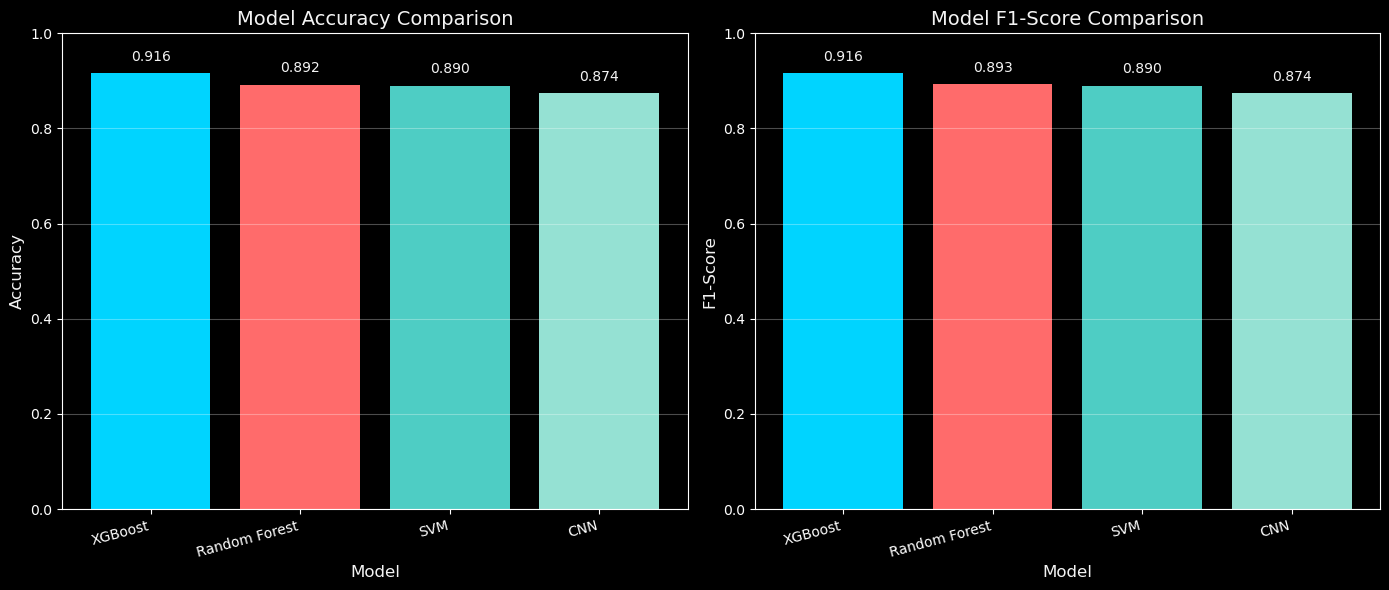


Best performing model: XGBoost
Best F1-score: 0.9162


In [25]:
## step 11, model comparison and visualization.
# here we compare all models side-by-side and create a summary table.

# debugging notes:
# - comparing classical ML (SVM, RF, XGBoost) vs deep learning (CNN).
# - metrics: accuracy and F1-score.
# - bar chart visualization for easy comparison.

# compile results
comparison_data = {
    'Model': ['SVM', 'Random Forest', 'XGBoost', 'CNN'],
    'Accuracy': [
        classical_results['SVM']['accuracy'],
        classical_results['Random Forest']['accuracy'],
        classical_results['XGBoost']['accuracy'],
        cnn_acc
    ],
    'F1-Score': [
        classical_results['SVM']['f1'],
        classical_results['Random Forest']['f1'],
        classical_results['XGBoost']['f1'],
        cnn_f1
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON - FINAL RESULTS")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# accuracy comparison
ax1.bar(comparison_df['Model'], comparison_df['Accuracy'], 
        color=['#00d4ff', '#ff6b6b', '#4ecdc4', '#95e1d3'])
ax1.set_xlabel('Model', fontsize=12, color='#f4f4f4')
ax1.set_ylabel('Accuracy', fontsize=12, color='#f4f4f4')
ax1.set_title('Model Accuracy Comparison', fontsize=14, color='#f4f4f4')
ax1.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3)

for i, (model, acc) in enumerate(zip(comparison_df['Model'], comparison_df['Accuracy'])):
    ax1.text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontsize=10, color='#f4f4f4')

# F1-score comparison
ax2.bar(comparison_df['Model'], comparison_df['F1-Score'], 
        color=['#00d4ff', '#ff6b6b', '#4ecdc4', '#95e1d3'])
ax2.set_xlabel('Model', fontsize=12, color='#f4f4f4')
ax2.set_ylabel('F1-Score', fontsize=12, color='#f4f4f4')
ax2.set_title('Model F1-Score Comparison', fontsize=14, color='#f4f4f4')
ax2.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax2.set_ylim(0, 1.0)
ax2.grid(axis='y', alpha=0.3)

for i, (model, f1) in enumerate(zip(comparison_df['Model'], comparison_df['F1-Score'])):
    ax2.text(i, f1 + 0.02, f'{f1:.3f}', ha='center', va='bottom', fontsize=10, color='#f4f4f4')

plt.tight_layout()
plt.show()

# determine best model
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']

print(f"\nBest performing model: {best_model_name}")
print(f"Best F1-score: {best_f1:.4f}")


<h2 style="text-align:center;">Summary and reflection</h2>

This task involved creating an audio classification pipeline and the provided UrbanSound8k sound dataset was used. Classical machine learning models were trained on the extracted features from audio files such as MFCC, chroma and spectral contrast. A convolutional neural network was also used, which was instead being trained on mel-spectrograms. Of the classical models, xgboost was best, having an FI-score of 0.9162. Comparatively though, the CNN still came out on top for actually identifying sounds properly as it can learn patterns straight from spectrograms, instead of having to rely on extracted features.


SHAP stood out to me as very useful for the classical machine learning models. I realized that it showed that MFCC based features were doing most of the work in assisting classical machines to visualize patterns in the audio data. The only issue i noticed is that some similar classes (like jackhammer vs drilling) are difficult to separate. Additionally, I attempted unsupervised K-Means on MFCCs, which only got a decent amount of basic true labels correct (An ARI of 0.3-0.4), this shows that sound that may look familiar in an MFCC don't always match up with the real correct category.